# Battery Models


**Author**: Sepehr Jafarzadeh

**Ferdowsi University of Mashhad**

## Introduction

### History
Luigi Galvani was the first to realize that certain combination of metals placed into contact with each other can lead to an electric potential difference (or rather, they can make the legs of a dead frog twitch, which we now understand to be from the potential difference due to the metals). Galvani created the first “electrochemical cell”. Alessandro Volta then combined several of these cells together to form the “voltaic pile”, which is what we would now call a battery.

![battery-cell](./images/battery-cell.PNG)

![voltaic-pile](./images/voltaic-pile.gif)

### What is a battery in a circuit
Battery refer to a device that can provide a fixed potential difference between two terminals. However experiments shows that the potential difference across the terminals of a battery is not always equal to the potential difference across the ideal battery, and several factors can affect that.

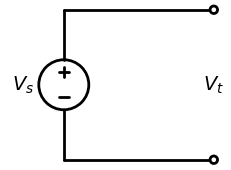

In [4]:
import schemdraw
from schemdraw import elements as e

with schemdraw.Drawing() as d:
    e.Gap().down().label('$V_t$')
    line = e.Line().left().idot(open=True)
    voltage_source = e.SourceV().up().label('$V_s$')
    e.Line().right().dot(open=True)



### Why to use battery models
We use battery models to be able to describe behaviors of batteries in different situations. There are several approaches to model a battery: ECM (Equivalent Circuit Model), Thermal models, Electrochemical models and so on. We will use ECM in this project. In this type of modeling we use electrical components (like resistor and capacitor) to describe batteries behavior.

## Rint model


### Explain Rint model
This model is the simplest and the most basic ECM. It consists of an ideal battery with open-circuit voltage $V_s$ and constant internal resistance $R_{int}$. The internal resistance exists because the materials that make the battery will themselves have a resistance. For example, if electrons want to leave the zinc rod in the electric cell , they will lose some energy as they pass through the zinc. This means that if current increases electrons will lose more energy, so the battery will create little voltage.


### Rint model schem

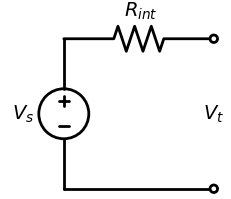

In [4]:
import schemdraw
from schemdraw import elements as e

with schemdraw.Drawing() as d:
    e.Gap().down().label('$V_t$')
    line = e.Line().left().idot(open=True)
    voltage_source = e.SourceV().up().label('$V_s$')
    internal_resistor = e.Resistor().right().label('$R_{int}$').dot(open=True)


### Analyze Rint model
To see how the $R_{int}$ affects the output voltage of the battery $V_t$, let's do a dc sweep analysis on the circuit below:

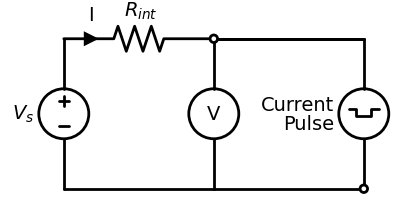

In [5]:
import schemdraw
from schemdraw import elements as e

with schemdraw.Drawing() as d:
    line1 = e.Line().right()
    e.SourcePulse().down().label('Current\nPulse')    
    line2 = e.Line().left().idot(open=True)
    line3 = e.Line().left()
    voltage_source = e.SourceV().up().label('$V_s$')
    internal_resistor = e.Resistor().right().label('$R_{int}$').dot(open=True)
    voltmeter = e.MeterV().at(internal_resistor.end).down()  # Adding the voltmeter between the two dots
    line = e.Line().at(internal_resistor.end).right()
    e.CurrentLabelInline().at(internal_resistor).label('I')



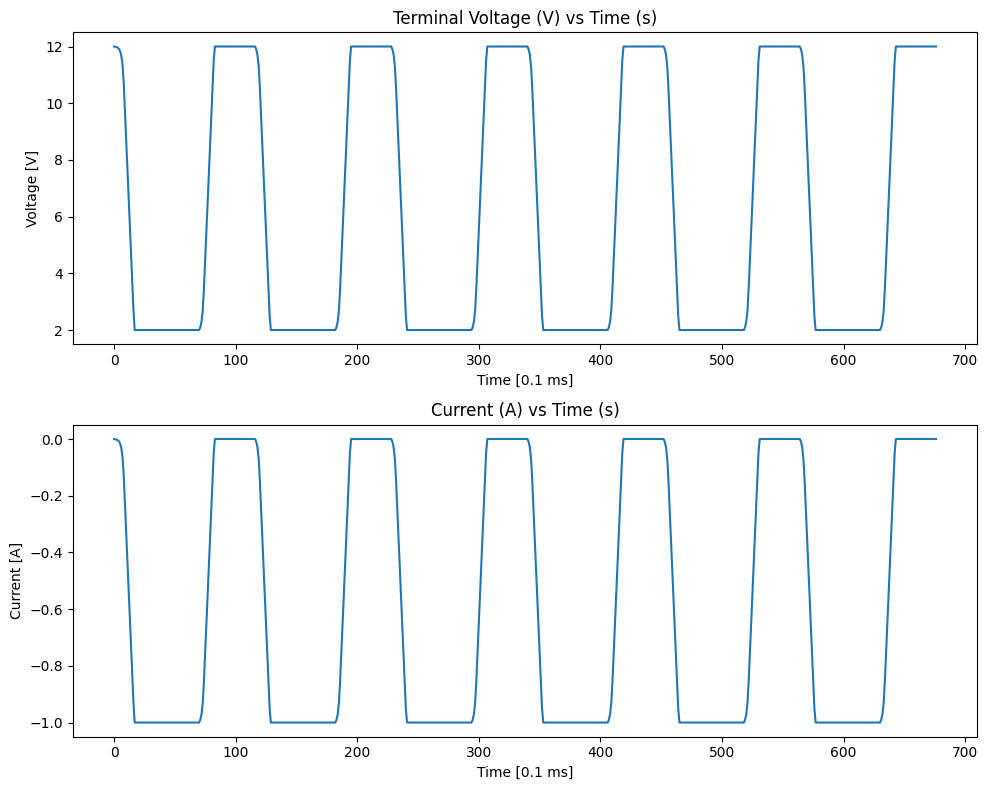

In [7]:
import matplotlib.pyplot as plt
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
from PySpice.Probe.Plot import plt as spice_plot

circuit = Circuit('Experiment on R_int model with variable current source')

# DC voltage source (Vs), internal resistance (R_int)
V_s = 12 @ u_V  # Example DC source voltage of 10V
R_int = 10 @ u_Ohm  # Internal resistance of 50 Ohms

circuit.V(1, 'n1', circuit.gnd, V_s)
circuit.R(1, 'n1', 'n2', R_int)


# pulse current source (current_pulse)
# PULSE parameters: (I1, I2, Delay, Rise Time, Fall Time, Pulse Width, Period)
current_pulse = circuit.I(1, 'n2', circuit.gnd, 'PULSE(0 1A 0s 1ms 1ms 5ms 10ms)')

# Run transient analysis
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=0.1 @ u_ms, end_time=60 @ u_ms)

plt.figure(figsize=(10, 8))

# Plot Terminal Voltage over time
plt.subplot(211)
plt.plot(analysis.nodes['n2'])
plt.title('Terminal Voltage (V) vs Time (s)')
plt.xlabel('Time [0.1 ms]')
plt.ylabel('Voltage [V]')

# Plot Current through the current source over time
plt.subplot(212)
plt.plot(analysis.branches['v1'])
plt.title('Current (A) vs Time (s)')
plt.xlabel('Time [0.1 ms]')
plt.ylabel('Current [A]')

plt.tight_layout()
plt.show()



### Calculations in Rint model

The voltage measured across the load resistor \($ V_{(t)} $\), can be calculated using Ohm's Law. 

Given the circuit:
\($ V_s $\): The open-circuit voltage of the battery (also called the Thevenin voltage).
\($ R_{int} $\): The internal resistance of the battery.
\($ R_{load} $\): The external load resistance.

The voltage across the load resistor $ V_{(t)} $ is calculated as:

\begin{align*}
V(t) &= V_0 - R_{int} \times I(t) \\
V_t &= \frac{R_{load}}{R_{int} + R_{load}} \times V_s \\
I(t) &= \frac{V(t)}{R_{load}}
\end{align*}



The second equation shows that as the load resistance increases, the terminal voltage approaches $ V_s $. Conversely, as the load resistance decreases,  $ V_{(t)} $ drops due to the voltage drop across $ R_{int} $.

In this simulation, we observed how the terminal voltage $ V_{(t)} $ varies with different load resistances.


## Second order RC model

### Explain second order RC model
In this model we have two RC pairs, one with low $C \times R$ ($C_s$ and $R_s$, 's' stands for short term) and another with high $C \times R$ ($C_l$ and $R_l$, 'l' stands for long term) beside the internal resistor. When the current flows through a battery changes, the response to this change is nonlinear. The short term RC pair generally represents the immediate dynamic response of the battery to load changes. And the long term RC pair represents the slower dynamics of the battery's response, capturing the long-term effects and behaviors.

### Second Order RC model schem

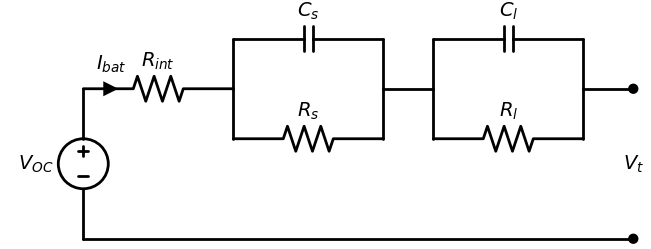

In [8]:
import schemdraw
from jedi.inference.utils import unite
from schemdraw import elements as e

with schemdraw.Drawing() as d:
    e.Gap().down().label('$V_t$')
    e.Line().left().length(11).idot()
    voltage_source = e.SourceV().up().label('$V_{OC}$')
    internal_resistor = e.Resistor().right().label('$R_{int}$')

    e.Line().up().length(1)
    capacitor_s = e.Capacitor().right().label('$C_{s}$')
    line = e.Line().down().length(1)
    e.Line().down().length(1)
    resistor_s = e.Resistor().left().label('$R_{s}$')
    e.Line().up().length(1)
    e.Line().at(line.end).right().length(1)

    e.Line().up().length(1)
    capacitor_l = e.Capacitor().right().label('$C_{l}$')
    line = e.Line().down().length(1)
    e.Line().down().length(1)
    resistor_l = e.Resistor().left().label('$R_{l}$')
    e.Line().up().length(1)
    e.Line().at(line.end).right().length(1).dot()

    e.CurrentLabelInline().at(internal_resistor).label('$I_{bat}$')




### Analyze second order RC model
To see how the two parallel RC pairs affect the terminal voltage we will do a transient analysis on this circuit.

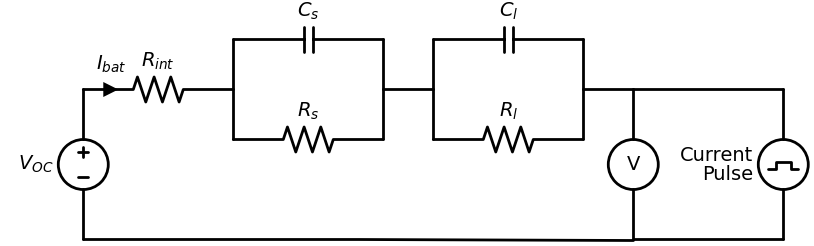

In [2]:
import schemdraw
from jedi.inference.utils import unite
from schemdraw import elements as e

with schemdraw.Drawing() as d:
    line1 = e.Line().left().length(11)
    voltage_source = e.SourceV().up().label('$V_{OC}$')
    internal_resistor = e.Resistor().right().label('$R_{int}$')

    e.Line().up().length(1)
    capacitor_s = e.Capacitor().right().label('$C_{s}$')
    line = e.Line().down().length(1)
    e.Line().down().length(1)
    resistor_s = e.Resistor().left().label('$R_{s}$')
    e.Line().up().length(1)
    e.Line().at(line.end).right().length(1)

    e.Line().up().length(1)
    capacitor_l = e.Capacitor().right().label('$C_{l}$')
    line = e.Line().down().length(1)
    e.Line().down().length(1)
    resistor_l = e.Resistor().left().label('$R_{l}$')
    e.Line().up().length(1)
    e.Line().at(line.end).right().length(1)

    e.MeterV().down()
    e.Line().right()
    e.SourcePulse().up().label('Current\nPulse')
    e.Line().left()

    e.CurrentLabelInline().at(internal_resistor).label('$I_{bat}$')




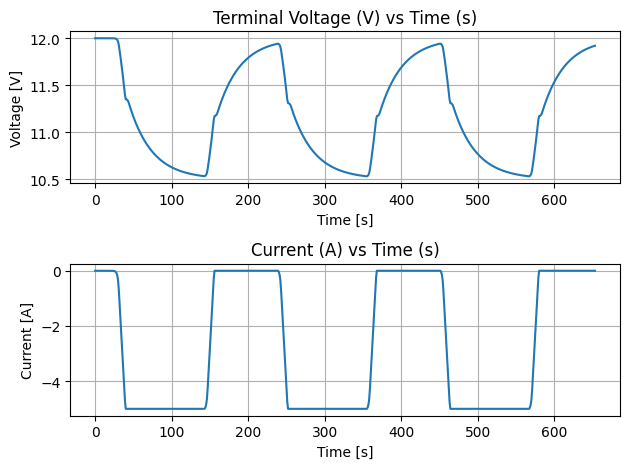

In [1]:
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
from PySpice.Probe.Plot import plt

# Create the Thevenin-based RC model with a variable current source
circuit = Circuit('Thevenin RC Model with Pulse Current Source')

# Define voltage source for open circuit voltage (Voc)
V_oc = 12@u_V  # Example battery voltage
circuit.V(1, 'node1', circuit.gnd, V_oc)

# Internal resistance (R0)
R_0 = 0.1@u_Ohm
circuit.R(1, 'node1', 'node2', R_0)

# RC pair: R1 and C1
R_1 = 0.2@u_Ohm
C_1 = 15@u_mF
circuit.R(2, 'node2', 'node3', R_1)
circuit.C(1, 'node2', 'node3', C_1)

# RC pair: R2 and C2
R_2 = 0.8@u_Ohm
C_2 = 200@u_mF
circuit.R(3, 'node3', 'node4', R_2)
circuit.C(2, 'node3', 'node4', C_2)

# Add an independent current source with a PULSE signal
circuit.I(1, 'node4', circuit.gnd, 'PULSE(0A 5A 1ms 1ms 1ms 10ms 20ms)')

# Run the transient analysis for 50 ms
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=0.1@u_ms, end_time=60@u_ms)

# Plot the terminal voltage (node1 to ground) and current over time
plt.figure(1)

# Voltage at node1 (battery terminal)
plt.subplot(211)
plt.plot(analysis.nodes['node3'])
plt.title('Terminal Voltage (V) vs Time (s)')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.grid()

# Access the current probe for 'I1' (the current source)
plt.subplot(212)
plt.plot(analysis.branches['v1'])
plt.title('Current (A) vs Time (s)')
plt.xlabel('Time [s]')
plt.ylabel('Current [A]')
plt.grid()

plt.tight_layout()
plt.show()


### Calculation in second order RC model
Applying Kirchhoff equations to this circuit:

\begin{align*}
V_{C_s}(t+1) &= V_{C_s}(t) \times e^{-\frac{T}{C_s \times R_s}} + R_s \times I_{Batt}(t) \times \left(1 - e^{-\frac{T}{C_s \times R_s}}\right) \\
V_{C_l}(t+1) &= V_{C_l}(t) \times e^{-\frac{T}{C_l \times R_l}} + R_l \times I_{Batt}(t) \times \left(1 - e^{-\frac{T}{C_l \times R_l}}\right) \\
V_{Batt} &= V_{OC}(SOC) - V_{C_l}(t) - V_{C_s}(t) - R_{series} \times I_{Batt}
\end{align*}

where $T$ represents the timestep and $t$ represents the simulation time. $V_{C_L}$
 and $V_{C_s}$ are the transient response with long- and short-time duration (voltage across $C_l$ and $C_s$
)



## Conclusion
The purpose of this homework was to provide a deeper understanding of battery behavior, particularly how challenging it can be to model their dynamic characteristics with complete accuracy. As we've seen, predicting a battery’s performance under varying conditions is complex. However, researchers are continuously developing methods, like equivalent circuit models (ECM), to approximate these behaviors more closely.

It's important to note that no single modeling approach can capture every aspect of battery dynamics perfectly. For more accurate results, it is often necessary to combine multiple modeling techniques.

## Resources
https://www.mdpi.com/1996-1073/14/11/3209#B12-energies-14-03209

" https://phys.libretexts.org/Bookshelves/University_Physics/Book%3A_Introductory_Physics_-_Building_Models_to_Describe_Our_World_(Martin_Neary_Rinaldo_and_Woodman)/20%3A_Electric_Circuits/20.01%3A_Batteries_and_Simple_Circuits "

https://cpb.iphy.ac.cn/article/2020/2032/cpb_29_6_068201.html

https://github.com/PySpice-org/PySpice